# Data Missingness Treatment

In [9]:
library(dplyr)
library(ggplot2)
if(!require(ggExtra)) {install.packages("ggExtra");require(ggExtra)}
if(!require(naniar)) {install.packages("naniar");require(naniar)}
if(!require(mvoutlier)) {install.packages("mvoutlier");require(mvoutlier)}
if(!require(MissMech)) {install.packages("MissMech");require(MissMech)}
if(!require(mice)) {install.packages("mice");require(mice)}
if(!require(MatchIt)) {install.packages("MatchIt");require(MatchIt)}
if(!require(DBI)){install.packages("DBI"); require(DBI)}
if(!require(RSQLite)){install.packages("RSQLite"); require(RSQLite)}
if(!require(funModeling)){install.packages("funModeling"); require(funModeling)}
if(!require(tidyr)){install.packages("tidyr"); require(tidyr)}



Loading required package: tidyr

Attaching package: 'tidyr'

The following object is masked from 'package:sjmisc':

    replace_na

The following object is masked from 'package:mice':

    complete



In [2]:
###Get Tomas Library
if(!require(devtools)){install.packages("devtools"); require(devtools)}
if(!require(mechkar)){install_github("karpatit/mechkar"); require(mechkar)}

Loading required package: devtools
Loading required package: mechkar
Loading required package: car
Loading required package: carData

Attaching package: 'car'

The following object is masked from 'package:dplyr':

    recode

Loading required package: sqldf
Warning message:
"package 'sqldf' was built under R version 3.5.2"Loading required package: gsubfn
Warning message:
"package 'gsubfn' was built under R version 3.5.2"Loading required package: proto
Loading required package: ROSE
Warning message:
"package 'ROSE' was built under R version 3.5.2"Loaded ROSE 0.0-3

Loading required package: pROC
Warning message:
"package 'pROC' was built under R version 3.5.2"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var

Loading required package: ResourceSelection
Warning message:
"package 'ResourceSelection' was built under R version 3.5.2"ResourceSelection 0.3-4 	 2019-01-08
Loading required package: sj

In [3]:
outlierMatrix <- function(data,threshold=1.5) {
    vn <- names(data)
    outdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        if(is.numeric(data[[v]])) {
            outlow <- quantile(data[[v]],probs = 0.25,na.rm = T) 
            outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
            irq_level <- (outhigh - outlow) * threshold
            outlow <- outlow - irq_level
            outhigh <- outhigh +  irq_level
            mv <- ifelse(data[[v]] < outlow | data[[v]] > outhigh, 1, 0)
            outdata[v] <- mv
        } else {
            mv <- rep(0,nrow(data))
        }
    }
    outdata$row1 <- NULL
    return(outdata)
}


missingMatrix <- function(data) {
    vn <- names(data)
    missdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        mv <- ifelse(is.na(data[[v]]),1,0)
        missdata[v] <- mv
    }
    missdata$row1 <- NULL
    return(missdata)
}

minmax <- function(x) {
    return(((x-min(x,na.rm=T))/(max(x,na.rm=T)-min(x,na.rm=T))))
}

getMissingness <- function (data, getRows = FALSE) {
    require(dplyr)
    l <- nrow(data)
    vn <- names(data)
    nadf <- data
    cnt <- NULL
    miss <- function(x) return(sum(is.na(x)))
    for (n in vn) {
        nadf[[n]] <- ifelse(is.na(nadf[[n]]) == T, 1, 0)
        cnt <- rbind(cnt, data.frame(n, sum(nadf[[n]])))
    }
    names(cnt) <- c("var", "na.count")
    cnt$rate <- round((cnt$na.count/nrow(nadf)) * 100, 1)
    nadf$na.cnt <- 0
    nadf$na.cnt <- rowSums(nadf)
    cnt <- cnt %>% dplyr::arrange(desc(na.count)) %>% dplyr::filter(na.count > 
        0)
    totmiss <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::tally()
    idx <- NULL
    msg <- (paste("This dataset has ", as.character(totmiss), 
        " (", as.character(round(totmiss/nrow(data) * 100, 1)), 
        "%)", " complete rows. Original data has ", nrow(data), 
        " rows.", sep = ""))
    if (getRows == TRUE & totmiss != 0) {
        nadf$rn <- seq_len(nrow(data))
        idx <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::select(rn)
    }
    print(list(head(cnt, n = 10), msg))
    return(list(missingness = cnt, message = msg, rows = idx$rn))
}

In [4]:
### load data
##DATA_PATH = "D:/Google Drive/Final Project/Data"
DATA_PATH = "C:/Users/Kobi/Google Drive/Final Project/Data"
file=(paste0(DATA_PATH, "/loans_db.csv"))
loans = read.csv(file)


In [5]:
split(names(loans),sapply(loans, function(x) paste(class(x), collapse=" ")))

$factor
 [1] "verification_status" "issue_d"             "purpose"            
 [4] "emp_length"          "addr_state"          "last_pymnt_d"       
 [7] "next_pymnt_d"        "last_credit_pull_d"  "home_ownership"     
[10] "earliest_cr_line"    "full_state"         

$integer
 [1] "loan_id"                     "pymnt_plan"                 
 [3] "initial_list_status"         "loan_amnt"                  
 [5] "funded_amnt"                 "term"                       
 [7] "out_prncp"                   "out_prncp_inv"              
 [9] "collections_12_mths_ex_med"  "mths_since_last_major_derog"
[11] "delinq_2yrs"                 "acc_now_delinq"             
[13] "inq_last_6mths"              "mths_since_last_delinq"     
[15] "mths_since_last_record"      "open_acc"                   
[17] "pub_rec"                     "revol_bal"                  
[19] "total_acc"                   "tot_coll_amt"               
[21] "open_acc_6m"                 "open_il_6m"                 
[23] "open_il_12m"                 "open_il_24m"                
[25] "mths_since_rcnt_il"          "total_bal_il"               
[27] "open_rv_12m"                 "open_rv_24m"                
[29] "max_bal_bc"                  "inq_fi"                     
[31] "total_cu_tl"                 "inq_last_12m"               

$logical
[1] "default"

$numeric
 [1] "funded_amnt_inv"         "installment"            
 [3] "total_pymnt"             "total_pymnt_inv"        
 [5] "total_rec_prncp"         "total_rec_int"          
 [7] "total_rec_late_fee"      "recoveries"             
 [9] "collection_recovery_fee" "last_pymnt_amnt"        
[11] "annual_inc"              "dti"                    
[13] "revol_util"              "tot_cur_bal"            
[15] "il_util"                 "all_util"               
[17] "total_rev_hi_lim"        "loan_installment"

In [6]:
## numeric variables
num_vars <- 
  loans %>% 
  sapply(is.numeric) %>% 
  which() %>% 
  names()
num_vars

[1] "loan_id"                     "pymnt_plan"                 
 [3] "initial_list_status"         "loan_amnt"                  
 [5] "funded_amnt"                 "funded_amnt_inv"            
 [7] "term"                        "installment"                
 [9] "out_prncp"                   "out_prncp_inv"              
[11] "total_pymnt"                 "total_pymnt_inv"            
[13] "total_rec_prncp"             "total_rec_int"              
[15] "total_rec_late_fee"          "recoveries"                 
[17] "collection_recovery_fee"     "last_pymnt_amnt"            
[19] "collections_12_mths_ex_med"  "mths_since_last_major_derog"
[21] "annual_inc"                  "dti"                        
[23] "delinq_2yrs"                 "acc_now_delinq"             
[25] "inq_last_6mths"              "mths_since_last_delinq"     
[27] "mths_since_last_record"      "open_acc"                   
[29] "pub_rec"                     "revol_bal"                  
[31] "revol_util"                  "total_acc"                  
[33] "tot_coll_amt"                "tot_cur_bal"                
[35] "open_acc_6m"                 "open_il_6m"                 
[37] "open_il_12m"                 "open_il_24m"                
[39] "mths_since_rcnt_il"          "total_bal_il"               
[41] "il_util"                     "open_rv_12m"                
[43] "open_rv_24m"                 "max_bal_bc"                 
[45] "all_util"                    "total_rev_hi_lim"           
[47] "inq_fi"                      "total_cu_tl"                
[49] "inq_last_12m"                "loan_installment"

In [7]:
loans <- loans %>% select(one_of(num_vars))
loans <- loans %>% select(-one_of(c('verif_1', 'verif_2' ,'verif_3' ,'purpose_1' ,'purpose_2' ,'purpose_3' ,'purpose_4', 'purpose_5' ,'purpose_6', 'purpose_7', 'purpose_8' ,'purpose_9' ,'purpose_10', 'purpose_11' ,'purpose_12' ,'purpose_13','purpose_14', 'seniority_1' ,'seniority_2' ,'seniority_3' ,'seniority_4', 'seniority_5','seniority_6', 'seniority_7','seniority_8' ,'seniority_9' ,'seniority_10' ,'seniority_11' ,'seniority_12' ,'owner_status_1' ,'owner_status_2' ,'owner_status_3', 'owner_status_4', 'owner_status_5' ,'owner_status_6')))

Warning message:
"Unknown columns: `verif_1`, `verif_2`, `verif_3`, `purpose_1`, `purpose_2`, `purpose_3`, `purpose_4`, `purpose_5`, `purpose_6`, `purpose_7`, `purpose_8`, `purpose_9`, `purpose_10`, `purpose_11`, `purpose_12`, `purpose_13`, `purpose_14`, `seniority_1`, `seniority_2`, `seniority_3`, `seniority_4`, `seniority_5`, `seniority_6`, `seniority_7`, `seniority_8`, `seniority_9`, `seniority_10`, `seniority_11`, `seniority_12`, `owner_status_1`, `owner_status_2`, `owner_status_3`, `owner_status_4`, `owner_status_5`, `owner_status_6`"

In [7]:
Table1(data = loans,x = num_vars,y = "default")

  |======================================================================| 100%

Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient covariances computed by hccm()
Coefficient

V1,V2,Pop,FALSE,TRUE,pval
Individuals,n,255720,209711,46009,NA
loan_id,Mean (SD),"12,145,621.4 (14,732,728.9)","12,436,958.1 (15,261,649.4)","10,817,696.4 (11,941,305.4)",NA
loan_id,Median (IQR),"6,190,618.5 (1,434,760.8-16,351,309.8)","6,167,281.0 (1,418,133.5-16,762,164.5)","6,524,813.0 (1,525,503.0-14,650,207.0)",0
pymnt_plan,Mean (SD),0.0 (0.0),0.0 (0.0),0.0 (0.0),NA
pymnt_plan,Median (IQR),0.0 (0.0-0.0),0.0 (0.0-0.0),0.0 (0.0-0.0),0.157
initial_list_status,Mean (SD),0.7 (0.4),0.7 (0.4),0.7 (0.4),NA
initial_list_status,Median (IQR),1.0 (0.0-1.0),1.0 (0.0-1.0),1.0 (0.0-1.0),0
loan_amnt,Mean (SD),"13,514.2 (8,127.1)","13,303.8 (8,053.3)","14,473.1 (8,388.9)",NA
loan_amnt,Median (IQR),"12,000.0 (7,200.0-18,200.0)","12,000.0 (7,075.0-18,000.0)","12,500.0 (8,000.0-20,000.0)",0
funded_amnt,Mean (SD),"13,471.8 (8,104.6)","13,263.0 (8,031.8)","14,423.7 (8,362.6)",NA


# Missingness

In [ ]:
missingMatrix(loans)

In [ ]:
getMissingness(loans)

In [ ]:
meta_loans <- funModeling::df_status(loans, print_results = FALSE)

In [ ]:
meta_loans %>%
  select(variable, p_zeros, p_na, unique)%>% filter(p_na>15) %>%  arrange(desc(p_na))

In [ ]:
naVector <- as.vector(meta_loans %>%
  select(variable, p_zeros, p_na, unique)%>% filter(p_na>15) %>%  arrange(desc(p_na)) %>%
  select(variable))
naVector <- dput(naVector)$variable

In [ ]:
loansCopy <- loans
loans <- loans %>% select(one_of(naVector))
loans

## Missing values visualization

In [ ]:
loans %>%
  sample_n(10000) %>%
  vis_miss()

In [ ]:
# require(naniar)
options(repr.plot.width = 8, repr.plot.height = 4)
gg_miss_fct(x=loans, fct=loan_id) + 
theme(axis.text.x = element_text(angle=90, size=8))

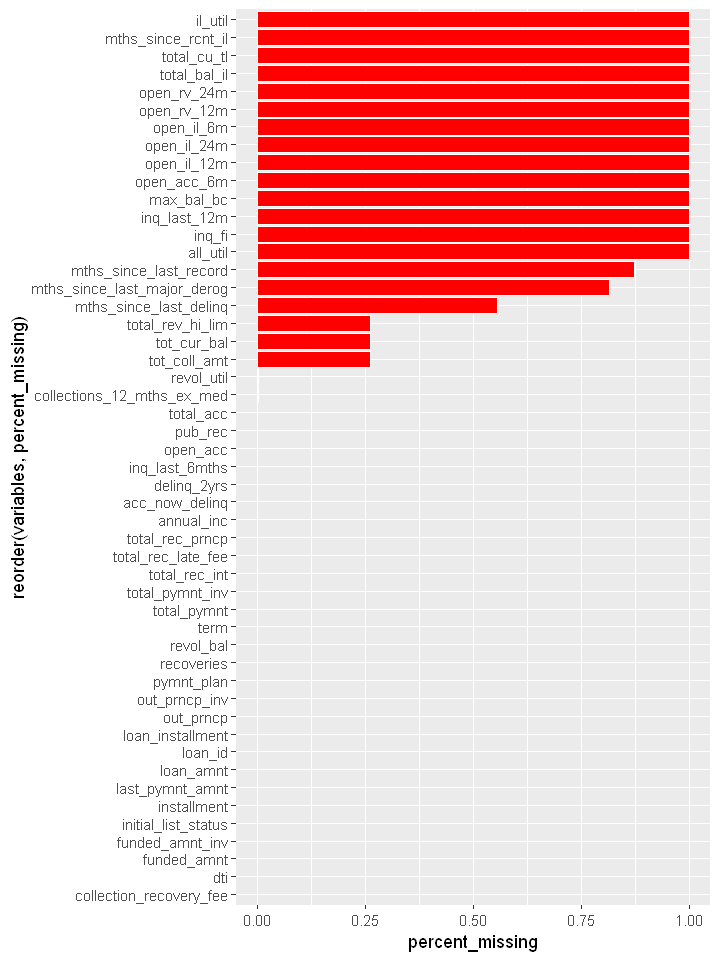

In [11]:
options(repr.plot.width=6, repr.plot.height=8)
missing_data <- loans %>% summarise_all(funs(sum(is.na(.))/n()))
missing_data <- gather(missing_data, key = "variables", value = "percent_missing") 
ggplot(missing_data, aes(x = reorder(variables, percent_missing), y = percent_missing)) +
  geom_bar(stat = "identity", fill = "red", aes(color = I('white')), size = 0.1)+coord_flip()

## Determinate the Missingness Generation Mechanism
 
There are three mechanisms that generate Missing values:
 
1. Missing Completely at Random (MCAR)
2. Missing at Random (MAR)
3. Missing not at Random (MNAR)
 
We will investigate the missingness mechanisms using different techniques.


In [ ]:
loans2 <- loans
##<- loans %>% sample_n(1000)
ncol(loans2)

In [ ]:
has_na <- sapply(loans2, function(x) any(is.na(x)))
loans2 <- loans2[has_na]               
has_na

In [ ]:
head(loans2)

In [ ]:
miss1 <- TestMCARNormality(loans2)
miss1

In [ ]:
### Impute missing values

miss1 <- TestMCARNormality(data=loans2,method="Nonparametric", del.lesscases = 1, imputation.number = 10)
summary(miss1)


In [ ]:
options(repr.plot.width = 6, repr.plot.height = 8)
boxplot(miss1)

In [ ]:
summary(miss1$imputed.data)

loans.imp <- data.frame(miss1$imputed.data)
idx <- miss1$caseorder

head(loans.imp)
dim(loans.imp)

In [ ]:
## Visualize the imputed missing values using scatter plots 
options(repr.plot.width = 8, repr.plot.height = 8)

misspoints <- missingMatrix(loans[idx,])
loans.imp <- data.frame(miss1$imputed.data)
par(mfrow=c(4,3))
for(v in names(loans.imp)) {
    scatter.smooth(loans.imp[[v]] ~ loans[idx,"loan_id"], main=v, xlab="loans",ylab=v, family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints[idx,v]+1)
}
par(mfrow=c(1,1))


## MICE: Multiple Imputation with Chained Equations 

In [ ]:
# library(mice)
init = mice(loans, maxit=0) 
meth = init$method
predM = init$predictorMatrix

In [ ]:
meth

In [ ]:
predM

In [ ]:
### Pedict the missing values
set.seed(103)
imputed = mice(loans, method=meth, predictorMatrix=predM, m=5)

In [ ]:
summary(imputed)

In [ ]:
summary(imputed$imp)
imp1 <- complete(imputed,1)
dim(imp1)

In [ ]:
imputed.full <- complete(imputed,action="long")
dim(imputed.full)

In [ ]:
## Check if there are any missing on the imputed data
sapply(imputed, function(x) sum(is.na(x)))

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 8)

misspoints <- missingMatrix(animals)
animals.imp <- complete(imputed,1)
par(mfrow=c(4,3))
for(v in names(animals)) {
    scatter.smooth(animals.imp[[v]] ~ animals[,"species"], main=v, xlab="animals",ylab=v, family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints[,v]+1)
}
par(mfrow=c(1,1))


In [ ]:
options(repr.plot.width = 8, repr.plot.height = 8)

misspoints <- missingMatrix(animals)
animals.imp <- complete(imputed,5)
par(mfrow=c(4,3))
for(v in names(animals)) {
    scatter.smooth(animals.imp[[v]] ~ animals[,"species"], main=v, xlab="animals",ylab=v, family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints[,v]+1)
}
par(mfrow=c(1,1))


In [ ]:
### gt on each of the five imputations
par(mfrow=c(4,3))

## mice imputation #1
scatter.smooth(complete(imputed,1)[["gt"]] ~ animals[,"species"], main="mice imputation #1", xlab="animals",ylab="gt", family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints$gt+1)

## mice imputation #2
scatter.smooth(complete(imputed,2)[["gt"]] ~ animals[,"species"], main="mice imputation #2", xlab="animals",ylab="gt", family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints$gt+1)

## mice imputation #3
scatter.smooth(complete(imputed,3)[["gt"]] ~ animals[,"species"], main="mice imputation #3", xlab="animals",ylab="gt", family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints$gt+1)

## mice imputation #4
scatter.smooth(complete(imputed,4)[["gt"]] ~ animals[,"species"], main="mice imputation #4", xlab="animals",ylab="gt", family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints$gt+1)

## mice imputation #5
scatter.smooth(complete(imputed,5)[["gt"]] ~ animals[,"species"], main="mice imputation #5", xlab="animals",ylab="gt", family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints$gt+1)

par(mfrow=c(1,1))


# Propensity Score

In [ ]:
## require(MatchIt)

animals2 <- animals[,c('species', 'bw', 'brw', 'pi', 'sei', 'odi')]
animals2$sws_miss <- ifelse(is.na(animals$sws)==T, 1, 0)
summary(animals2)

In [ ]:
m.out <- matchit(sws_miss ~ bw + brw + pi + sei + odi, data = animals2, method = "nearest", ratio = 1)
summary(m.out)


In [ ]:
  options(repr.plot.width = 8, repr.plot.height = 8)
plot(m.out, type = "hist")

The MatchIt package has many methods for propensity score matching:
 
1. "exact" - matches each treated unit with a control unit that has exactly the same values on each covariate.
2. "subclass" - breaks the data set into subclasses such that the distributions of the covariates are similar in each subclass 
3. "nearest" - matches a treated unit to a control unit by means of that is closest in terms of a distance measure (nearest neighbor)
4. "optimal" - focuses on minimizing the average absolute distance across all matched pairs 
5. "genetic" - uses a computationally intensive genetic search algorithm to match treatment and control units 
6. "cem" - (Coarsened Exact Matching) matches on a covariate while maintaining the balance of other covariates
 


In [ ]:
animals.matched <- match.data(m.out) 
animals.matched %>% arrange(distance)
